In [1]:
import numpy as np
from utils import *
import csv
import keras.utils
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import save_model,load_model,Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, UpSampling2D, AveragePooling2D, MaxPooling2D, Dense,Input, Dropout
from tensorflow.keras.layers import LeakyReLU,Reshape,BatchNormalization, Flatten
from tensorflow.keras.models import save_model
from tempfile import TemporaryFile
import tensorflow as tf
import pickle
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython import display
import time
from sklearn.mixture import GaussianMixture
import umap
from copy import deepcopy
from PIL import Image
from sklearn.cluster import KMeans
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
#from tensorflow.keras.layers.merge import add
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD
from array import array 
import json
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import mode
import joblib
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Some libraries that needs to be installed

# ! pip install umap-learn
# ! pip install  keras
# ! pip install matplotlib
# ! pip install np_utils


In [3]:
zdim=32 # This is the dimension of intermediate latent variable 
nofclasses=2 # Binary for PAD


## This Function Fits a GMM to the Data  Representations

In [4]:
def MgGMMfit(encoderX,classifier,dataX_train,labelX_train,nofclasses):
    gmmX = encoderX.predict(dataX_train)
    
    gmmY = np.argmax(labelX_train,axis=1)
    yper = classifier.predict(encoderX.predict(dataX_train))
    yper = np.argmax(yper, axis=1)
    gmmX = gmmX[gmmY==yper,:]
    gmmY = gmmY[gmmY==yper]
    gmmModel =  GaussianMixture(n_components=nofclasses,covariance_type='full', init_params='kmeans', tol=1e-04) 
    gmmModel.fit(gmmX,gmmY)
    gmmModelSingle =  GaussianMixture(n_components=1,covariance_type='full') 

    for i in range(nofclasses):
        a= gmmX[gmmY==i,:]
        gmmModelSingle.fit(a)
        gmmModel.weights_[i] = 1/float(nofclasses)#gmmY[gmmY==i].shape[0]/gmmY.shape[0]
        gmmModel.covariances_[i] = gmmModelSingle.covariances_[0]
        gmmModel.means_[i] = gmmModelSingle.means_[0]

        gmmModel.precisions_cholesky_[i] = gmmModelSingle.precisions_cholesky_[0]
        gmmModel.precisions_[i] = gmmModelSingle.precisions_[0]
        
    return gmmModel


## Metric Functions

In [5]:
def APCER(y,yh):
    indCL = np.where(y==1)[0]
    y1 = y[indCL]
    y2 = yh[indCL]
    return (1-((1*(y1==y2)).sum()/len(y1)))
    

In [6]:
def BFCER(y,yh):
    indCL = np.where(y==0)[0]
    y1 = y[indCL]
    y2 = yh[indCL]
    return (1-((1*(y1==y2)).sum()/len(y1)))
    

In [7]:
def MAPCER(y,yh):

    return .5*(APCER(y,yh)+BFCER(y,yh))
    

## Loading Data

In [8]:
data1 = joblib.load('/nas/home/mrostami/CL-CVPR2021/Data/batl_data/batl_all_features_part0_train')
data2 = joblib.load('/nas/home/mrostami/CL-CVPR2021/Data/batl_data/batl_all_features_part1_train')
data3 = joblib.load('/nas/home/mrostami/CL-CVPR2021/Data/batl_data/batl_all_features_part2_train')

x1 = data1['features']
y1 = data1['labels']
intind1 = np.random.permutation(y1.shape[0])

x1 = x1[intind1,:]
y1 = y1[intind1]

yb1 = y1.copy()
x = x1 
y = y1 
yb = yb1 

yb[yb != 0] = 1

dataX_train= x.copy()
y_train = yb.copy()

ytrain = y.copy()




data1 = joblib.load('/nas/home/mrostami/CL-CVPR2021/Data/batl_data/batl_all_features_part0_test')


x1 = data1['features']
y1 = data1['labels']
intind1 = np.random.permutation(y1.shape[0])

x1 = x1[intind1,:]
y1 = y1[intind1]

yb1 = y1.copy()


x = x1 
y = y1 
yb = yb1
yb[yb != 0] = 1

dataX_test= x.copy()
y_test = yb.copy()

labelX_train = keras.utils.to_categorical(y_train, nofclasses)
labelX_test = keras.utils.to_categorical(y_test, nofclasses)
ytest = y.copy()



numClass = len(np.unique(y))

In [32]:
len(np.unique(y))

10

In [33]:
for i in range(ytrain.shape[0]):
    if ytrain[i] != 0 and ytrain[i] !=1:
        ytrain[i] = int((ytrain[i]+2)/2)
 
        
for i in range(ytest.shape[0]):                
    if ytest[i] != 0 and ytest[i] != 1:
        ytest[i] = int((ytest[i]+2)/2)    
        
numClass = 6

##  X is input and Z the embedding space

In [34]:

 
imgX = Input(shape=(128, ) )  # adapt this if using `channels_first` image data format
imgY = Input(shape=(128, ) )

 
labelX=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot



## Encoder  and Classifier NN

In [35]:
def encoderXNN(imgX):



    hidden_size = 64
    x=Dense(hidden_size,activation = 'relu')(imgX)

    x=Dense(int(hidden_size/2),activation = 'relu')(x)
    #x=Dense(hidden_size/32,activation = 'sigmoid')(x)

    x=Dense(int(hidden_size/4),activation = 'relu')(x)


    encodedX=Dense(zdim)(x)

    encoderX=Model(inputs=[imgX],outputs=[encodedX])



    return encoderX
    #encoderX.summary()


In [36]:
def classifierNN(nofclasses,yin):
    
    
    probX=Dense(nofclasses,activation='softmax')(yin)
    classifier=Model(inputs=[yin],outputs=[probX])
    return classifier



## This function is used for to select the samples of attacks at each time

In [37]:
 def selectSample(labelX_train,numTask):
    for i in range(2*numTask+2):
        if i == 0:
            indCL =  np.where(np.argmax(labelX_train,axis=1)==i)[0]
        else:
            indCL = np.concatenate([indCL ,np.where(np.argmax(labelX_train,axis=1)==i)[0]])            
    return indCL

## This function generates negative samples that we use to add the third output to the network

In [38]:
def genNegative(gmm,classifier):
    
    numsamplegen = 50000
    L = {}
    for ncom in range(gmm.n_components):
    
    
        L[ncom] = np.linalg.cholesky(gmm.covariances_[ncom])
     

        u = np.random.normal(loc=0, scale=1, size=zdim*numsamplegen).reshape(numsamplegen,zdim)
        L1 = L[ncom]
        X11 =  2*  np.matmul(u,L1.T) 
        X1 = np.zeros([X11.shape[0],X11.shape[1]])
        for i in range(numsamplegen):
            X1[i,:] = gmm.means_[ncom] + X11[i,:]

        if ncom == 0:
            X = X1
            XM = X11
        else:
            X = np.concatenate([X,X1])
            XM = np.concatenate([XM,X11])
    Dist = {}
    for ncom in range(gmm.n_components):
        dist1 = np.zeros(XM.shape[0])
        for i in range(XM.shape[0]):
            x = XM[i,:]
            dist1[i] = np.matmul(x.T, np.matmul(np.linalg.inv(gmm.covariances_[ncom]),x))
        Dist[ncom] = dist1
    
    for ncom in range(gmm.n_components):
        if ncom == 0:
            tempvar = Dist[ncom]
            indToT  = tempvar> tempvar[:numsamplegen].mean()
        else:
            tempvar = Dist[ncom]
            indToT = np.logical_and( indToT , tempvar> tempvar[ncom*numsamplegen:(ncom+1)*numsamplegen:].mean())
    
    Xtr = X[ indToT ,:]

    probprid = classifier.predict(Xtr) 
    prob = np.max(probprid,axis=1)

    Xlowconf = Xtr[prob<.99]
    Xsample = Xlowconf.shape[0]
    NegSamp = Xlowconf
    
    return NegSamp
    

## This function selects 20 samples that are closest to the GMM componenets to be stored in the buffer

In [39]:
def Mbuffer(gmm,encoderX,dataX_train1CL,labelX_trainCL):
    
    buffsize = 50
    embeded = encoderX.predict(dataX_train1CL)
    labels = np.argmax(labelX_trainCL,axis=1)
    NclassToT = gmm.n_components
    
    Nclass = np.unique(labels).shape[0]
    
    
    
    for i in range(NclassToT-Nclass,NclassToT):
         
        Dist = np.zeros(dataX_train1CL.shape[0])
        for j in range(dataX_train1CL.shape[0]):
            Dist[j] =  np.matmul(np.matmul((embeded[j,...]-gmm.means_[i]).T,np.linalg.inv(gmm.covariances_[i])),embeded[j,...]-gmm.means_[i])
        Dist = -Dist
        Dist[labels != i] = 1e100
        ind = Dist.argsort()[-int(buffsize):][::-1]
        
        if i == NclassToT-Nclass:
            outData = dataX_train1CL[ind,...]
            outLab = labelX_trainCL[ind,...]
             
        else:
            outData = np.concatenate([outData,dataX_train1CL[ind,...]], axis = 0)
            outLab = np.concatenate([outLab,labelX_trainCL[ind,...]], axis = 0)
                 
        
    return   outData, outLab


In [40]:
## Saving the models after learning each attack
Classifier = []
Encoder = []
Decoder = []
GMMs = []
 

# Training  and Testing

In [41]:
def getres(dataX_train,labelX_train,dataX_test,labelX_test,numClass):
# at each CL we learn one attack
    # Result Variables
    
    loss = []
    testXperf = []
    APCERperf = []
    BFCERperf = []
    MAPCERperf = []
    APCERperfT = []
    BFCERperfT = []
    MAPCERperfT = []
    Beffuacc = []  # Label Pollution

 

    imgX = Input(shape=(128, ) )  # adapt this if using `channels_first` image data format
    imgY = Input(shape=(128, ) )


    labelX=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot



    encoderX = encoderXNN(imgX)
    yin =  Input(shape=(zdim,) )
    yintest = Input(shape=(zdim,) )
    # Epochs
    epochs = 2000
    epochstep = epochs/100 
    batchsize=100 

    #Test Set is Fixed
    dataX_test1CLtot = dataX_test
    labelX_testCLtot = labelX_test
    


    for cl in range(numClass): 


        # Extracting the training data
        if cl == 0:
            indCL = np.where(ytrain==0)[0]
            labelX_trainCL1 =  labelX_train[indCL,:] 
            dataX_train1CL1 =  dataX_train[indCL,...]

            indCL = np.where(ytrain==1)[0]
            labelX_trainCL2 =  labelX_train[indCL,:] 
            dataX_train1CL2 =  dataX_train[indCL,...]

            dataX_train1CL = np.concatenate([dataX_train1CL1,dataX_train1CL2],axis=0)
            labelX_trainCL = np.concatenate([labelX_trainCL1,labelX_trainCL2],axis=0)



        #Test Set Includes only classes seen so far
        if cl == 0:
            indCLtest = np.where(ytest==0)[0]
            labelX_testCL1 =  labelX_test[indCLtest,:] 
            dataX_test1CL1 =  dataX_test[indCLtest,...]

            indCLtest = np.where(ytest==1)[0]
            labelX_testCL2 =  labelX_test[indCLtest,:] 
            dataX_test1CL2 =  dataX_test[indCLtest,...]

            dataX_test1CL = np.concatenate([dataX_test1CL1,dataX_test1CL2],axis=0)
            labelX_testCL = np.concatenate([labelX_testCL1,labelX_testCL2],axis=0)

        else:
            indCLtest = np.where(ytest==cl+1)[0]
            labelX_testCL1 =  labelX_test[indCLtest,:] 
            dataX_test1CL1 =  dataX_test[indCLtest,...]

            dataX_test1CL = np.concatenate([dataX_test1CL,dataX_test1CL1],axis=0)
            labelX_testCL = np.concatenate([labelX_testCL,labelX_testCL1],axis=0)    



        # Loss function definition
        classifier = classifierNN(2,yin)
        if cl == 0:
            labelX=K.placeholder(shape=(None,2),dtype='float32') #labels of input images oneHot
            discriminationLoss=K.mean(K.binary_crossentropy(labelX,classifier(encoderX(imgX))))    
            myLoss=  discriminationLoss
            params = encoderX.weights + classifier.weights  
            opt = Adam(lr=2e-4,decay = 1e-4,amsgrad=True)
            updates = opt.get_updates(myLoss,params)
            train = K.function(inputs=[imgX,labelX],outputs=[myLoss],updates=updates)
        else:
            labelX=K.placeholder(shape=(None,2),dtype='float32') #labels of input images oneHot
            discriminationLoss=K.mean(K.binary_crossentropy(labelX,classifier(encoderX(imgX))))  
            matchingloss = K.mean(K.categorical_crossentropy(yintest,encoderX(imgY)))
            myLoss=  discriminationLoss + 1e-4*matchingloss
            params = encoderX.weights + classifier.weights  
            opt = Adam(lr=2e-4,decay = 1e-4,amsgrad=True)
            updates = opt.get_updates(myLoss,params)
            train = K.function(inputs=[imgX,labelX,imgY,yintest],outputs=[myLoss],updates=updates)



        for itr in range(epochs):

            if cl == 0:   
                indTrainDataX,trainLabelX=batchGenerator(labelX_trainCL,batchsize,nofclasses=2)
                trainDataX=dataX_train1CL[indTrainDataX,...]
                loss.append(train(inputs=[trainDataX,trainLabelX]))
            else:
                indTrainDataX,trainLabelX=batchGenerator(labelX_trainCL,batchsize,nofclasses=2)
                trainDataX=dataX_train1CL[indTrainDataX,...]
                buffembed = encoderX.predict(outDataBuffer)      
                #loss.append(train(inputs=[trainDataX,trainLabelX]))
                loss.append(train(inputs=[trainDataX,trainLabelX,outDataBuffer,buffembed]))   
                
                
                
                
                
               
        yreal = np.argmax(labelX_testCL,axis=1)
        
        perd_label_X = classifier.predict(encoderX.predict(dataX_test1CL))
        yhat = np.argmax(perd_label_X,axis=1)
        testXperf.append(100*float(sum(1*(np.argmax(perd_label_X,axis=1)==np.argmax(np.squeeze(labelX_testCL),axis=1))))/labelX_testCL.shape[0])
        
        APCERperf.append(APCER(yreal,yhat))
        BFCERperf.append(BFCER(yreal,yhat))
        MAPCERperf.append(MAPCER(yreal,yhat))  

        perd_label_Xtot = classifier.predict(encoderX.predict(dataX_test1CLtot))
        yrealtot = np.argmax(labelX_testCLtot,axis=1)
        yhattot = np.argmax(perd_label_Xtot,axis=1)            

        APCERperfT.append(APCER(yrealtot,yhattot))
        BFCERperfT.append(BFCER(yrealtot,yhattot))
        MAPCERperfT.append(MAPCER(yrealtot,yhattot))  


        if cl ==numClass-2:
            break

        ####  GMM fitting   
        gmm = MgGMMfit(encoderX,classifier,dataX_train1CL,labelX_trainCL,2)
        GMMs.append(gmm)
        #### Buffer Samples
        outDataBuffer, outLabBuffer = Mbuffer(gmm,encoderX,dataX_train1CL,labelX_trainCL)
        
        if cl == 0:
            tmplabBF = outLabBuffer[:int(outLabBuffer.shape[0]/2),:] 
            tmpdataBF = outDataBuffer[:int(outLabBuffer.shape[0]/2),:] 
        else:
            outDataBuffer[:int(outLabBuffer.shape[0]/2),:]  = tmpdataBF
            outLabBuffer[:int(outLabBuffer.shape[0]/2),:]  = tmplabBF        

        
        #### Computing Pollution
        perd_label_X = classifier.predict(encoderX.predict(outDataBuffer))
        Beffuacc.append(100*float(sum(1*(np.argmax(perd_label_X,axis=1)==np.argmax(np.squeeze(outLabBuffer),axis=1))))/outLabBuffer.shape[0])



        Encoder.append(encoderX)
        #### Negative Samples
        NegSamp = genNegative(gmm,classifier)
        encodedOld = encoderX.predict(dataX_train1CL)
        augSamp = np.concatenate([encodedOld,NegSamp],axis=0)
        augLabs = np.concatenate([np.argmax(labelX_trainCL,axis=1) ,(2)*np.ones(NegSamp.shape[0])],axis=0) 
        AugLabs = keras.utils.to_categorical(augLabs, 2+1)

        #### Increasing the network output to learn OTDS
        classifier = classifierNN(2+1,yin) 
        labelZ=K.placeholder(shape=(None,2+1),dtype='float32') #labels of input images oneHot
        imgZ=Input(((zdim),)) #Input image 
        discriminationLoss=K.mean(K.binary_crossentropy(labelZ,classifier(imgZ)))
        myLoss=  discriminationLoss  
        params= classifier.weights  
        opt = Adam(lr=1e-3,decay = 1e-3,amsgrad=True)
        updates = opt.get_updates(myLoss,params)
        train = K.function(inputs=[imgZ,labelZ],outputs=[discriminationLoss],updates=updates)
        # Updating the network
        for itr in range(epochs):

            indTrainDataX,trainLabelX=batchGenerator(AugLabs,batchsize,nofclasses=2+1)
            trainDataX=augSamp[indTrainDataX,...]
            loss.append(train(inputs=[trainDataX,trainLabelX]))

        ### Testing the network on samples of the next attack
        indCLNew = np.where(ytrain==cl+2)[0]
        labelX_trainCL_New =  labelX_train[indCLNew,...] 
        dataX_train1CL_New =  dataX_train[indCLNew,...]         

        dataX_train1CL_New = np.concatenate([dataX_train1CL,dataX_train1CL_New],axis=0) 
        labelX_trainCL_New = np.concatenate([labelX_trainCL,labelX_trainCL_New],axis=0) 

        perLabstask2 = classifier.predict(encoderX.predict(dataX_train1CL_New))
        # Sampoles identified as new attacks
        newData = dataX_train1CL_New[np.argmax(perLabstask2,axis=1)==2,:]
        newLabel = np.argmax(labelX_trainCL_New[np.argmax(perLabstask2,axis=1)==2,:] ,axis=1)


     # updating the model by adding the new training data       
        if newData.shape[0] !=0:
            embededNewData = encoderX.predict(newData)
            perdlabels = np.ones(newData.shape[0])# Lables are predicted by model. We don't use true labels

            # The model is updated on both the new data and samples in the buffer in the next step above
            dataX_train1CL = np.concatenate([outDataBuffer,newData],axis=0) 
            augmented_Label = np.concatenate([np.argmax(outLabBuffer,axis=1),perdlabels]) 
            labelX_trainCL = keras.utils.to_categorical(augmented_Label, 2 )
        else:
            dataX_train1CL = outDataBuffer
            labelX_trainCL = outLabBuffer

        
        
    APCERperf = np.array(APCERperf)
    BFCERperf = np.array(BFCERperf)
    MAPCERperf = np.array(MAPCERperf)
    APCERperfT = np.array(APCERperfT)
    BFCERperfT = np.array(BFCERperfT)
    MAPCERperfT = np.array(MAPCERperfT)
    testXperf = np.array(testXperf)
        
    return APCERperf,BFCERperf,MAPCERperf,APCERperfT,BFCERperfT,MAPCERperfT,testXperf


In [42]:
numtrial = 10



APCERperfTot = np.zeros([numClass-1,numtrial])
BFCERperfTot = np.zeros([numClass-1,numtrial])
MAPCERperfTot = np.zeros([numClass-1,numtrial])
APCERperfTTot = np.zeros([numClass-1,numtrial])
BFCERperfTTot = np.zeros([numClass-1,numtrial])
MAPCERperfTTot = np.zeros([numClass-1,numtrial])
testXperfTot = np.zeros([numClass-1,numtrial])


for i in range(numtrial):
    print(i)
    APCERperf,BFCERperf,MAPCERperf,APCERperfT,BFCERperfT,MAPCERperfT,testXperf =  getres(dataX_train,labelX_train,dataX_test,labelX_test,numClass)
    print(BFCERperf)
    APCERperfTot[:,i] = APCERperf
    BFCERperfTot[:,i] = BFCERperf
    MAPCERperfTot[:,i] = MAPCERperf
    APCERperfTTot[:,i] = APCERperfT
    BFCERperfTTot[:,i] = BFCERperfT
    MAPCERperfTTot[:,i] = MAPCERperfT
    testXperfTot[:,i] = testXperf


0
[0.00550964 0.08264463 0.12396694 0.14049587 0.14876033]
1
[0.00275482 0.0661157  0.09917355 0.08815427 0.09090909]
2
[0.00275482 0.07713499 0.09917355 0.12121212 0.12396694]
3
[0.00275482 0.06060606 0.10192837 0.1046832  0.11019284]
4
[0.00275482 0.07988981 0.09641873 0.09090909 0.10192837]
5
[0.00550964 0.06887052 0.09090909 0.0661157  0.06060606]
6
[0.00275482 0.07162534 0.1184573  0.12672176 0.1322314 ]
7
[0.00275482 0.06336088 0.09366391 0.11019284 0.12396694]
8
[0.00275482 0.0661157  0.09366391 0.08264463 0.0661157 ]
9
[0.00550964 0.07713499 0.09917355 0.09641873 0.0661157 ]


In [43]:
np.mean(BFCERperfTot[:,2:],axis=1)

array([0.00344353, 0.07059229, 0.09917355, 0.09986226, 0.0981405 ])

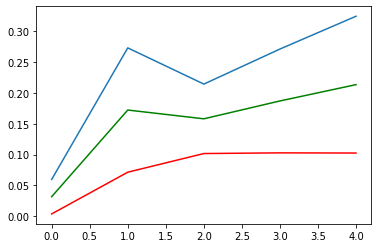

In [44]:
plt.plot(np.mean(APCERperfTot,axis=1)) 
plt.plot(np.mean(BFCERperfTot,axis=1),'r') 
plt.plot(np.mean(MAPCERperfTot,axis=1),'g') 



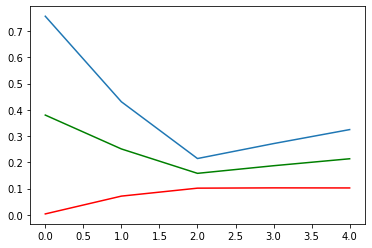

In [51]:
plt.plot(np.mean(APCERperfTTot,axis=1)) 
plt.plot(np.mean(BFCERperfTTot,axis=1),'r') 
plt.plot(np.mean(MAPCERperfTTot,axis=1),'g') 


In [52]:
 np.mean(BFCERperfTTot,axis=1)

array([0.00358127, 0.07134986, 0.10165289, 0.10275482, 0.10247934])

In [53]:
## Save Results if needed

np.save('A-NACL.npy',np.mean(APCERperfTot,axis=1))
np.save('B-NACL.npy',np.mean(BFCERperfTot,axis=1))
np.save('M-NACL.npy',np.mean(MAPCERperfTot,axis=1))

In [54]:

## Save Results if needed

np.save('AT-NACL.npy',np.mean(APCERperfTTot,axis=1))
np.save('BT-NACL.npy',np.mean(BFCERperfTTot,axis=1))
np.save('MT-NACL.npy',np.mean(MAPCERperfTTot,axis=1))
